# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.091943,True,8.689047
1,1.643546,True,8.613824
2,-0.401242,False,-1.077298
3,2.170307,False,4.493023
4,0.447527,True,6.517920
...,...,...,...
995,0.728639,False,2.272975
996,0.500575,True,6.103960
997,0.125664,True,6.170720
998,2.009225,False,6.097101


<AxesSubplot: xlabel='v0'>

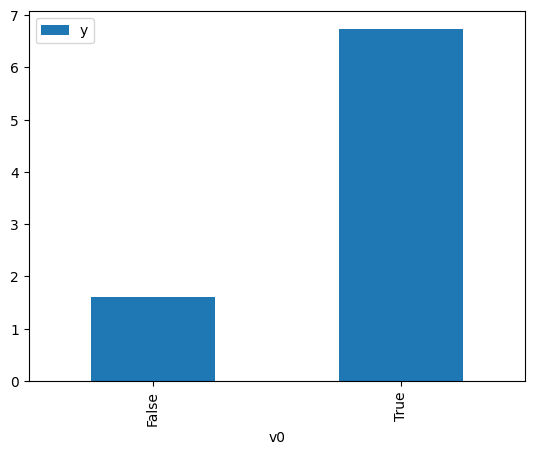

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

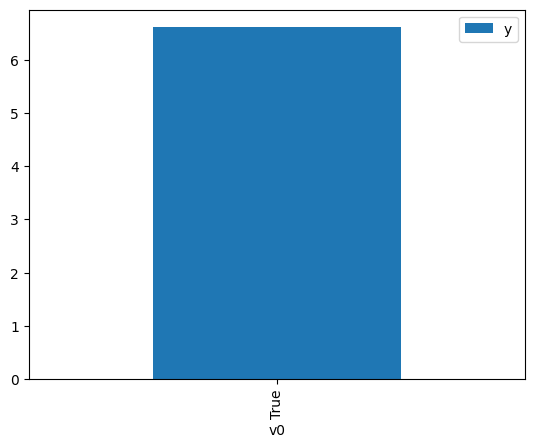

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.960555,False,2.638709,0.495506,2.018138
1,0.599058,False,1.682217,0.499222,2.003118
2,0.750373,False,2.512907,0.497666,2.009378
3,1.056210,False,2.684077,0.494523,2.022150
4,-0.008410,False,1.142565,0.505465,1.978376
...,...,...,...,...,...
995,1.900856,False,2.086185,0.485845,2.058268
996,0.787624,False,1.513574,0.497284,2.010925
997,0.303828,False,0.779890,0.502256,1.991016
998,-0.012414,False,1.087694,0.505506,1.978215


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.928496,True,10.864545,0.514438,1.943867
1,2.494131,True,10.596746,0.520245,1.922171
2,-0.814933,True,1.964153,0.486248,2.056562
3,1.514449,True,9.296734,0.510185,1.960072
4,-0.615327,True,3.995846,0.488299,2.047927
...,...,...,...,...,...
995,1.342267,True,7.791229,0.508416,1.966892
996,0.247720,True,5.601818,0.497167,2.011396
997,1.818305,True,7.596072,0.513307,1.948153
998,0.827041,True,6.131272,0.503121,1.987592


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.476e+04
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:36:18   Log-Likelihood:                         -1399.8
No. Observations:                1000   AIC:                                      2804.
Df Residuals:                     998   BIC:                                      2813.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2851      0.029     78.787      0.000       2.228       2.342
x2             5.0084      0.049    102.717      0.000       4.913       5.104
==============================================================================
Omnibus:                        0.150   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.222
Skew:                           0.014   Prob(JB):                        0.895
Kurtosis:                       2.933   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""